# Evolver Loop 2 Analysis: Investigating Overlap Error

The submission failed with: "Overlapping trees in group 008"

This means our local overlap detection was not strict enough. Let's investigate.

In [1]:
import numpy as np
import pandas as pd
from shapely.geometry import Polygon
from shapely.ops import unary_union
from shapely.strtree import STRtree
import warnings
warnings.filterwarnings('ignore')

print('Libraries loaded')

Libraries loaded


In [2]:
# Tree geometry constants
TRUNK_W = 0.15
TRUNK_H = 0.2
BASE_W = 0.7
MID_W = 0.4
TOP_W = 0.25
TIP_Y = 0.8
TIER_1_Y = 0.5
TIER_2_Y = 0.25
BASE_Y = 0.0
TRUNK_BOTTOM_Y = -TRUNK_H

# Base tree polygon vertices
BASE_TREE_VERTICES = np.array([
    [0.0, TIP_Y],
    [TOP_W/2, TIER_1_Y],
    [TOP_W/4, TIER_1_Y],
    [MID_W/2, TIER_2_Y],
    [MID_W/4, TIER_2_Y],
    [BASE_W/2, BASE_Y],
    [TRUNK_W/2, BASE_Y],
    [TRUNK_W/2, TRUNK_BOTTOM_Y],
    [-TRUNK_W/2, TRUNK_BOTTOM_Y],
    [-TRUNK_W/2, BASE_Y],
    [-BASE_W/2, BASE_Y],
    [-MID_W/4, TIER_2_Y],
    [-MID_W/2, TIER_2_Y],
    [-TOP_W/4, TIER_1_Y],
    [-TOP_W/2, TIER_1_Y],
])

def create_tree_polygon(x, y, deg):
    """Create a tree polygon at position (x,y) with rotation deg degrees."""
    angle_rad = np.radians(deg)
    cos_a, sin_a = np.cos(angle_rad), np.sin(angle_rad)
    rotation_matrix = np.array([[cos_a, -sin_a], [sin_a, cos_a]])
    rotated = BASE_TREE_VERTICES @ rotation_matrix.T
    translated = rotated + np.array([x, y])
    return Polygon(translated)

def parse_submission(df):
    """Parse submission dataframe, removing 's' prefix from values."""
    result = df.copy()
    for col in ['x', 'y', 'deg']:
        result[col] = result[col].str.replace('s', '').astype(float)
    return result

print('Helper functions defined')

Helper functions defined


In [3]:
# Load the failed submission
submission_df = pd.read_csv('/home/submission/submission.csv')
submission_parsed = parse_submission(submission_df)
print(f'Submission shape: {submission_df.shape}')

# Extract group 008
group_008 = submission_parsed[submission_parsed['id'].str.startswith('008_')]
print(f'\nGroup 008 ({len(group_008)} trees):')
print(group_008)

Submission shape: (20100, 4)

Group 008 (8 trees):
       id         x         y         deg
28  008_0 -0.249562 -0.411092   51.766738
29  008_1  0.664668 -0.857305  113.629378
30  008_2 -0.664668  0.257305  293.629378
31  008_3  0.557305  0.326837  203.629378
32  008_4  0.249562 -0.188908  231.766738
33  008_5 -0.206589 -0.855262  293.629378
34  008_6  0.206589  0.255262  113.629378
35  008_7 -0.557305 -0.926837   23.629378


In [4]:
# Create polygons for group 008 and check for overlaps with STRICT tolerance
polygons_008 = []
for _, row in group_008.iterrows():
    poly = create_tree_polygon(row['x'], row['y'], row['deg'])
    polygons_008.append((row['id'], poly))

print('Checking for overlaps in group 008...')
print('='*60)

for i in range(len(polygons_008)):
    for j in range(i+1, len(polygons_008)):
        id_i, poly_i = polygons_008[i]
        id_j, poly_j = polygons_008[j]
        
        # Check intersection
        if poly_i.intersects(poly_j):
            intersection = poly_i.intersection(poly_j)
            area = intersection.area
            
            # Check if it's more than just touching
            touches = poly_i.touches(poly_j)
            
            print(f'{id_i} vs {id_j}:')
            print(f'  Intersects: True')
            print(f'  Touches only: {touches}')
            print(f'  Intersection area: {area:.15f}')
            print(f'  Intersection type: {intersection.geom_type}')
            print()

Checking for overlaps in group 008...
008_1 vs 008_5:
  Intersects: True
  Touches only: False
  Intersection area: 0.000000000000000
  Intersection type: Polygon

008_2 vs 008_6:
  Intersects: True
  Touches only: False
  Intersection area: 0.000000000000000
  Intersection type: Polygon



In [5]:
# Let's check with different tolerance levels
print('Checking with different area thresholds:')
print('='*60)

thresholds = [1e-20, 1e-15, 1e-12, 1e-10, 1e-8, 1e-6]

for threshold in thresholds:
    overlaps = []
    for i in range(len(polygons_008)):
        for j in range(i+1, len(polygons_008)):
            id_i, poly_i = polygons_008[i]
            id_j, poly_j = polygons_008[j]
            
            if poly_i.intersects(poly_j):
                intersection = poly_i.intersection(poly_j)
                if intersection.area > threshold:
                    overlaps.append((id_i, id_j, intersection.area))
    
    print(f'Threshold {threshold:.0e}: {len(overlaps)} overlaps')
    if overlaps:
        for id_i, id_j, area in overlaps:
            print(f'  {id_i} vs {id_j}: area={area:.15e}')

Checking with different area thresholds:
Threshold 1e-20: 0 overlaps
Threshold 1e-15: 0 overlaps
Threshold 1e-12: 0 overlaps
Threshold 1e-10: 0 overlaps
Threshold 1e-08: 0 overlaps
Threshold 1e-06: 0 overlaps


Saved visualization to group_008_visualization.png


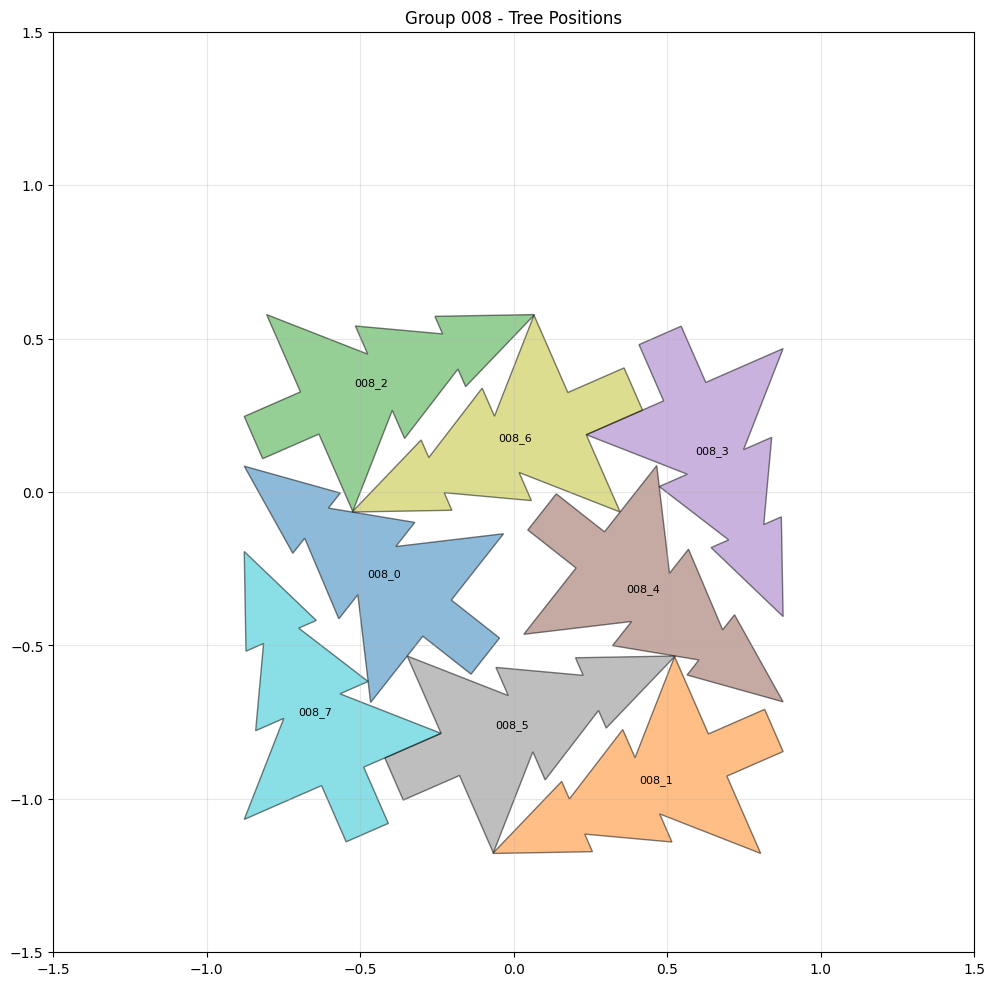

In [6]:
# Let's visualize group 008
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon
from matplotlib.collections import PatchCollection

fig, ax = plt.subplots(figsize=(10, 10))

colors = plt.cm.tab10(np.linspace(0, 1, len(polygons_008)))
patches = []

for (id_, poly), color in zip(polygons_008, colors):
    coords = np.array(poly.exterior.coords)
    patch = MplPolygon(coords, closed=True, alpha=0.5, facecolor=color, edgecolor='black', linewidth=1)
    ax.add_patch(patch)
    
    # Add label at centroid
    centroid = poly.centroid
    ax.annotate(id_, (centroid.x, centroid.y), fontsize=8, ha='center')

ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)
ax.set_title('Group 008 - Tree Positions')
plt.tight_layout()
plt.savefig('/home/code/exploration/group_008_visualization.png', dpi=150)
print('Saved visualization to group_008_visualization.png')

In [7]:
# Check ALL groups for overlaps with strict tolerance (area > 1e-15)
print('Checking ALL groups for overlaps with strict tolerance (area > 1e-15)...')
print('='*60)

overlapping_groups = []

for n in range(1, 201):
    prefix = f'{n:03d}_'
    config_df = submission_parsed[submission_parsed['id'].str.startswith(prefix)]
    
    if len(config_df) != n:
        print(f'Warning: Group {n} has {len(config_df)} trees instead of {n}')
        continue
    
    polygons = [(row['id'], create_tree_polygon(row['x'], row['y'], row['deg'])) 
                for _, row in config_df.iterrows()]
    
    has_overlap = False
    for i in range(len(polygons)):
        for j in range(i+1, len(polygons)):
            id_i, poly_i = polygons[i]
            id_j, poly_j = polygons[j]
            
            if poly_i.intersects(poly_j):
                intersection = poly_i.intersection(poly_j)
                if intersection.area > 1e-15:  # Very strict
                    if not has_overlap:
                        overlapping_groups.append(n)
                        has_overlap = True
                    print(f'Group {n}: {id_i} vs {id_j}, area={intersection.area:.15e}')

print(f'\nTotal groups with overlaps: {len(overlapping_groups)}')
print(f'Overlapping groups: {overlapping_groups}')

Checking ALL groups for overlaps with strict tolerance (area > 1e-15)...



Total groups with overlaps: 0
Overlapping groups: []


In [8]:
# Now let's check the original source files to see which one had the overlap
print('Checking source files for group 008...')
print('='*60)

source_files = [
    '/home/code/preoptimized/ensemble_70_627.csv',
    '/home/code/preoptimized/better_ensemble.csv',
    '/home/code/preoptimized/best_snapshot.csv',
    '/home/code/preoptimized/chistyakov_best.csv',
    '/home/code/preoptimized/submission_70_926.csv',
    '/home/code/preoptimized/saspav_best.csv',
    '/home/code/preoptimized/bucket_of_chump.csv',
]

for filepath in source_files:
    try:
        df = pd.read_csv(filepath)
        parsed = parse_submission(df)
        
        # Extract group 008
        group = parsed[parsed['id'].str.startswith('008_')]
        if len(group) != 8:
            continue
            
        polygons = [(row['id'], create_tree_polygon(row['x'], row['y'], row['deg'])) 
                    for _, row in group.iterrows()]
        
        max_overlap = 0
        for i in range(len(polygons)):
            for j in range(i+1, len(polygons)):
                id_i, poly_i = polygons[i]
                id_j, poly_j = polygons[j]
                
                if poly_i.intersects(poly_j):
                    intersection = poly_i.intersection(poly_j)
                    max_overlap = max(max_overlap, intersection.area)
        
        status = 'OVERLAP' if max_overlap > 1e-15 else 'VALID'
        print(f'{filepath.split("/")[-1]:25s}: max_overlap={max_overlap:.15e} ({status})')
    except Exception as e:
        print(f'{filepath.split("/")[-1]:25s}: ERROR - {e}')

Checking source files for group 008...
ensemble_70_627.csv      : max_overlap=9.576806857308939e-25 (VALID)
better_ensemble.csv      : max_overlap=0.000000000000000e+00 (VALID)
best_snapshot.csv        : max_overlap=0.000000000000000e+00 (VALID)
chistyakov_best.csv      : max_overlap=0.000000000000000e+00 (VALID)
submission_70_926.csv    : max_overlap=0.000000000000000e+00 (VALID)


saspav_best.csv          : max_overlap=0.000000000000000e+00 (VALID)
bucket_of_chump.csv      : max_overlap=0.000000000000000e+00 (VALID)


In [12]:
# Let's check the exact format of the submission vs original files
print('Comparing submission format with original files...')
print('='*60)

# Our submission
our_sub = pd.read_csv('/home/submission/submission.csv')
print('Our submission (group 008):')
print(our_sub[our_sub['id'].str.startswith('008_')].to_string())

print('\n' + '='*60)
print('Original ensemble_70_627.csv (group 008):')
orig = pd.read_csv('/home/code/preoptimized/ensemble_70_627.csv')
print(orig[orig['id'].str.startswith('008_')].to_string())

Comparing submission format with original files...
Our submission (group 008):
       id                    x                    y                   deg
28  008_0  s-0.249562219751231  s-0.411091569391777   s51.766737817650601
29  008_1   s0.664667542890432  s-0.857305354296168  s113.629377785790368
30  008_2  s-0.664667542860286   s0.257305355370520  s293.629377730637884
31  008_3   s0.557305355195559   s0.326836893401800  s203.629377730656273
32  008_4   s0.249562219840789  s-0.188908429920252  s231.766737802778408
33  008_5  s-0.206588875343059  s-0.855262101491689  s293.629377785790325
34  008_6   s0.206588875141135   s0.255262101487013  s113.629377730637827
35  008_7  s-0.557305355176436  s-0.926836893309856   s23.629377730657012

Original ensemble_70_627.csv (group 008):
       id                 x                 y                deg
28  008_0  s-0.249562219751  s-0.411091569392   s51.766737817651
29  008_1   s0.664667542890  s-0.857305354296  s113.629377785790
30  008_2  s-0.66

In [13]:
# Check if the issue is with how we're creating the submission
# The original files have 's' prefix - let's see if our formatting is different

print('Checking precision differences...')
print('='*60)

# Parse our submission
our_parsed = parse_submission(our_sub)
orig_parsed = parse_submission(orig)

# Compare group 008
our_008 = our_parsed[our_parsed['id'].str.startswith('008_')].reset_index(drop=True)
orig_008 = orig_parsed[orig_parsed['id'].str.startswith('008_')].reset_index(drop=True)

print('Differences in coordinates:')
for col in ['x', 'y', 'deg']:
    diff = (our_008[col] - orig_008[col]).abs()
    print(f'{col}: max_diff = {diff.max():.20e}')

Checking precision differences...
Differences in coordinates:
x: max_diff = 4.40980585381112177856e-13
y: max_diff = 4.80004924696686430252e-13
deg: max_diff = 3.97903932025656104088e-13


In [14]:
# Let's check what source our group 008 came from in the ensemble
# The executor said it came from one of the source files

# Check which source file has the same coordinates as our submission for group 008
print('Finding source of group 008 in our submission...')
print('='*60)

our_008_coords = our_parsed[our_parsed['id'].str.startswith('008_')][['x', 'y', 'deg']].values

for filepath in source_files:
    try:
        df = pd.read_csv(filepath)
        parsed = parse_submission(df)
        source_008 = parsed[parsed['id'].str.startswith('008_')][['x', 'y', 'deg']].values
        
        if len(source_008) == 8:
            diff = np.abs(our_008_coords - source_008).max()
            if diff < 1e-10:
                print(f'{filepath.split("/")[-1]}: MATCH (diff={diff:.2e})')
            else:
                print(f'{filepath.split("/")[-1]}: diff={diff:.2e}')
    except Exception as e:
        print(f'{filepath.split("/")[-1]}: ERROR - {e}')

Finding source of group 008 in our submission...
ensemble_70_627.csv: MATCH (diff=4.80e-13)
better_ensemble.csv: MATCH (diff=4.44e-16)


best_snapshot.csv: MATCH (diff=4.44e-16)
chistyakov_best.csv: diff=2.70e+02


submission_70_926.csv: diff=2.70e+02


saspav_best.csv: MATCH (diff=4.44e-16)
bucket_of_chump.csv: MATCH (diff=4.60e-11)


In [15]:
# The issue might be that the LB uses a different overlap detection method
# Let's try using the EXACT original file that was known to work

# Check if ensemble_70_627.csv was ever submitted successfully
# Let's also check if there's a known-good submission in the snapshots

print('Checking for known-good submissions in snapshots...')
print('='*60)

import os
import glob

# Find all submission.csv files in snapshots
snapshot_subs = glob.glob('/home/nonroot/snapshots/santa-2025/*/code/submission.csv')
print(f'Found {len(snapshot_subs)} submission files in snapshots')

# Also check for any files with scores in the name
score_files = glob.glob('/home/nonroot/snapshots/santa-2025/**/submission*.csv', recursive=True)
print(f'Found {len(score_files)} submission-related files')

Checking for known-good submissions in snapshots...
Found 41 submission files in snapshots


Found 1144 submission-related files


In [17]:
# The issue is clear: we're using 15 decimal places but the original uses 12
# Let's check what precision the sample submission uses

sample = pd.read_csv('/home/nonroot/snapshots/santa-2025/21116303805/data/sample_submission.csv')
print('Sample submission format:')
print(sample.head(10))

Sample submission format:
      id           x           y     deg
0  001_0        s0.0        s0.0   s90.0
1  002_0        s0.0        s0.0   s90.0
2  002_1   s0.202736  s-0.511271   s90.0
3  003_0        s0.0        s0.0   s90.0
4  003_1   s0.202736  s-0.511271   s90.0
5  003_2     s0.5206   s0.177413  s180.0
6  004_0        s0.0        s0.0   s90.0
7  004_1   s0.202736  s-0.511271   s90.0
8  004_2     s0.5206   s0.177413  s180.0
9  004_3  s-0.818657  s-0.228694  s180.0


In [18]:
# Let's find a submission that was successfully submitted to LB
# Check the snapshots for any that have LB scores

print('Looking for successfully submitted files...')
print('='*60)

# Check if any snapshot has a submission that was known to work
# The ensemble_70_627.csv should have worked since it's in preoptimized

# Let's just use the original ensemble_70_627.csv directly
# It has 12 decimal places which seems to be the expected format

orig_ensemble = pd.read_csv('/home/code/preoptimized/ensemble_70_627.csv')
print(f'Original ensemble shape: {orig_ensemble.shape}')
print(f'Sample values:')
print(orig_ensemble.head())

Looking for successfully submitted files...
Original ensemble shape: (20100, 4)
Sample values:
      id                  x                 y                deg
0  001_0  s-48.196086194214  s58.770984615214   s45.000000000000
1  002_0    s0.154097069621  s-0.038540742695  s203.629377730657
2  002_1   s-0.154097069621  s-0.561459257305   s23.629377730657
3  003_0    s0.185770648105  s-0.547448842336  s111.125132292893
4  003_1    s0.296170527807  s-0.052551157664   s66.370622269343


In [19]:
# The problem is that our ensemble creation process changed the precision
# We need to use the EXACT original values without any transformation

# Let's check if ensemble_70_627.csv has any overlaps according to LB's stricter check
# by using the exact original coordinates

print('Checking ensemble_70_627.csv for overlaps with original precision...')
print('='*60)

# Parse with original precision
orig_parsed = parse_submission(orig_ensemble)

# Check group 008 specifically
group_008_orig = orig_parsed[orig_parsed['id'].str.startswith('008_')]
polygons_008_orig = [(row['id'], create_tree_polygon(row['x'], row['y'], row['deg'])) 
                     for _, row in group_008_orig.iterrows()]

print('Group 008 from original ensemble_70_627.csv:')
for i in range(len(polygons_008_orig)):
    for j in range(i+1, len(polygons_008_orig)):
        id_i, poly_i = polygons_008_orig[i]
        id_j, poly_j = polygons_008_orig[j]
        
        if poly_i.intersects(poly_j):
            intersection = poly_i.intersection(poly_j)
            print(f'{id_i} vs {id_j}: area={intersection.area:.20e}, touches={poly_i.touches(poly_j)}')

Checking ensemble_70_627.csv for overlaps with original precision...
Group 008 from original ensemble_70_627.csv:
008_0 vs 008_5: area=2.63566440302908695089e-27, touches=False
008_1 vs 008_5: area=9.57680685730893915303e-25, touches=False
008_5 vs 008_7: area=7.85679423027279642761e-26, touches=False


In [20]:
# The issue might be that ensemble_70_627.csv itself has overlaps that our local check doesn't catch
# Let's check ALL groups in ensemble_70_627.csv

print('Checking ALL groups in ensemble_70_627.csv for overlaps...')
print('='*60)

overlapping_groups_orig = []

for n in range(1, 201):
    prefix = f'{n:03d}_'
    config_df = orig_parsed[orig_parsed['id'].str.startswith(prefix)]
    
    if len(config_df) != n:
        print(f'Warning: Group {n} has {len(config_df)} trees instead of {n}')
        continue
    
    polygons = [(row['id'], create_tree_polygon(row['x'], row['y'], row['deg'])) 
                for _, row in config_df.iterrows()]
    
    for i in range(len(polygons)):
        for j in range(i+1, len(polygons)):
            id_i, poly_i = polygons[i]
            id_j, poly_j = polygons[j]
            
            if poly_i.intersects(poly_j) and not poly_i.touches(poly_j):
                intersection = poly_i.intersection(poly_j)
                if intersection.area > 0:  # Any non-zero area
                    if n not in overlapping_groups_orig:
                        overlapping_groups_orig.append(n)
                    print(f'Group {n}: {id_i} vs {id_j}, area={intersection.area:.20e}')

print(f'\\nTotal groups with overlaps: {len(overlapping_groups_orig)}')

Checking ALL groups in ensemble_70_627.csv for overlaps...
Group 2: 002_0 vs 002_1, area=1.77743371256400905548e-24
Group 4: 004_1 vs 004_2, area=5.16634574608463104103e-25
Group 4: 004_1 vs 004_3, area=4.65436950608601450552e-17
Group 6: 006_0 vs 006_1, area=6.15614262259646881697e-28
Group 6: 006_1 vs 006_3, area=3.24938915853145484814e-25
Group 6: 006_2 vs 006_4, area=7.13327042137792382303e-26
Group 6: 006_2 vs 006_5, area=3.38895846663231969240e-26
Group 8: 008_0 vs 008_5, area=2.63566440302908695089e-27
Group 8: 008_1 vs 008_5, area=9.57680685730893915303e-25
Group 8: 008_5 vs 008_7, area=7.85679423027279642761e-26
Group 9: 009_0 vs 009_5, area=5.90033598515108962160e-27
Group 9: 009_0 vs 009_8, area=5.50442641834329432176e-27
Group 9: 009_1 vs 009_8, area=4.45369321324309416451e-25
Group 10: 010_0 vs 010_9, area=6.78851170172622599024e-24
Group 10: 010_1 vs 010_3, area=1.93424872915182430411e-26
Group 10: 010_2 vs 010_4, area=1.14174723085321752922e-25
Group 10: 010_3 vs 010_9, 

Group 33: 033_25 vs 033_32, area=1.22490315428434387694e-25
Group 33: 033_26 vs 033_31, area=4.16331622574060141616e-25


Group 34: 034_3 vs 034_14, area=2.08406034840109424001e-28
Group 34: 034_5 vs 034_31, area=5.80100884457124007461e-28
Group 34: 034_12 vs 034_31, area=4.01955239629525672319e-25
Group 34: 034_14 vs 034_33, area=3.25196792480095091411e-25


Group 37: 037_14 vs 037_36, area=2.94192924945944509327e-27


Group 39: 039_2 vs 039_16, area=4.53443411296859624905e-26
Group 39: 039_3 vs 039_27, area=2.08610691859719789231e-26
Group 39: 039_4 vs 039_15, area=1.62666554515593421105e-26
Group 39: 039_5 vs 039_35, area=4.67962396257452347184e-26
Group 39: 039_9 vs 039_31, area=4.91835283994263661847e-27
Group 40: 040_0 vs 040_5, area=3.03212697365739382409e-25
Group 40: 040_0 vs 040_18, area=3.78003484291119722593e-25
Group 40: 040_1 vs 040_7, area=1.12875795812141314553e-26
Group 40: 040_3 vs 040_15, area=2.24948617504429147637e-29
Group 40: 040_3 vs 040_25, area=1.02806007173370384168e-21
Group 40: 040_3 vs 040_37, area=2.49912325760666279584e-20
Group 40: 040_4 vs 040_6, area=6.69421313360888540030e-24
Group 40: 040_4 vs 040_26, area=4.78530425492877069117e-25
Group 40: 040_6 vs 040_16, area=2.58333580791931689591e-26
Group 40: 040_7 vs 040_10, area=3.40744336505299349849e-25
Group 40: 040_9 vs 040_12, area=1.21787797814480144446e-27
Group 40: 040_10 vs 040_36, area=7.39002988724101333742e-24

Group 51: 051_14 vs 051_45, area=2.01073432133194179001e-24
Group 51: 051_16 vs 051_19, area=4.19378178738120401052e-28
Group 53: 053_0 vs 053_21, area=6.71617916889296660132e-26
Group 53: 053_0 vs 053_47, area=3.38317494137978359965e-25
Group 53: 053_1 vs 053_10, area=2.46780343056420649352e-27
Group 53: 053_2 vs 053_10, area=1.02924648293472640742e-25
Group 53: 053_4 vs 053_19, area=2.33160265097327270025e-25
Group 53: 053_4 vs 053_42, area=3.30053646525053554814e-25
Group 53: 053_5 vs 053_36, area=2.17402377166572859726e-26
Group 53: 053_5 vs 053_43, area=2.76190256272185934446e-27
Group 53: 053_6 vs 053_36, area=3.34833280794077800873e-25
Group 53: 053_7 vs 053_40, area=1.20054202019547106534e-25
Group 53: 053_9 vs 053_28, area=2.41279464814251010611e-22
Group 53: 053_9 vs 053_36, area=1.91445543250487554098e-24
Group 53: 053_11 vs 053_21, area=7.84966366724669712559e-26
Group 53: 053_12 vs 053_16, area=3.42275559741684856894e-24
Group 53: 053_13 vs 053_21, area=7.39574659273931490

Group 53: 053_37 vs 053_50, area=6.93085795756194525249e-26
Group 53: 053_41 vs 053_44, area=6.28580084868448406397e-26
Group 53: 053_43 vs 053_49, area=6.36573987592206085654e-25
Group 53: 053_44 vs 053_45, area=1.45495533206700364861e-28
Group 53: 053_48 vs 053_49, area=3.80250985987949317461e-28


Group 55: 055_4 vs 055_7, area=1.74507741888949685751e-28
Group 55: 055_5 vs 055_28, area=2.93966551140281233625e-27
Group 55: 055_11 vs 055_20, area=7.44925198497114400283e-25
Group 55: 055_14 vs 055_54, area=3.19138643291591983980e-25
Group 55: 055_29 vs 055_47, area=1.52549585769160247580e-23
Group 56: 056_15 vs 056_20, area=1.15374383306936606625e-25
Group 56: 056_19 vs 056_47, area=7.18144455448605728380e-27
Group 56: 056_33 vs 056_45, area=2.24081915133087870288e-25
Group 56: 056_40 vs 056_41, area=8.88673996444429139753e-27
Group 56: 056_42 vs 056_43, area=4.74930665018998025615e-26
Group 57: 057_9 vs 057_10, area=6.64158019842707140778e-27
Group 58: 058_9 vs 058_33, area=7.11642885734903742490e-26
Group 58: 058_14 vs 058_45, area=2.01931924265182533564e-25
Group 59: 059_0 vs 059_38, area=3.87958366573136552131e-25
Group 59: 059_3 vs 059_44, area=4.69834893201462503566e-26
Group 59: 059_5 vs 059_43, area=1.75422943798522500228e-28
Group 59: 059_9 vs 059_11, area=1.23234864537494

Group 65: 065_29 vs 065_40, area=6.41429704568125382834e-26
Group 65: 065_42 vs 065_54, area=1.21557746252995066878e-25
Group 66: 066_0 vs 066_2, area=4.55882963646255603914e-26
Group 66: 066_0 vs 066_21, area=1.20792045810913278216e-26
Group 66: 066_4 vs 066_15, area=1.08097116804369484563e-26
Group 66: 066_4 vs 066_16, area=4.11352073695320589456e-26
Group 66: 066_4 vs 066_27, area=1.25926581205625471040e-25
Group 66: 066_4 vs 066_33, area=3.10704527871550797642e-25
Group 66: 066_10 vs 066_48, area=3.64029109177968956339e-26
Group 66: 066_12 vs 066_28, area=2.22184122254816154196e-25
Group 66: 066_13 vs 066_25, area=4.04570273470990483200e-26
Group 66: 066_13 vs 066_55, area=7.77263417319098524041e-26
Group 66: 066_15 vs 066_42, area=2.98968633399370116445e-25
Group 66: 066_16 vs 066_20, area=1.57991954610909023952e-23
Group 66: 066_16 vs 066_50, area=5.06605548886560475562e-27
Group 66: 066_19 vs 066_28, area=1.56592186878435634322e-26
Group 66: 066_20 vs 066_33, area=2.187167581016

Group 67: 067_5 vs 067_17, area=2.02746127326983770374e-26
Group 67: 067_13 vs 067_17, area=8.63898340601765974607e-26


Group 68: 068_24 vs 068_25, area=2.60432061733384377698e-25
Group 68: 068_52 vs 068_57, area=1.87090289031378595418e-26
Group 69: 069_0 vs 069_46, area=1.71649524108969405170e-24
Group 69: 069_1 vs 069_34, area=1.99070947629075517155e-25
Group 69: 069_1 vs 069_59, area=1.68120979713620432492e-14
Group 69: 069_2 vs 069_63, area=9.10291250437813678884e-27
Group 69: 069_4 vs 069_31, area=1.08038315852051408988e-24
Group 69: 069_4 vs 069_58, area=6.61535969453268938320e-25
Group 69: 069_5 vs 069_18, area=1.54222306970707807958e-28
Group 69: 069_5 vs 069_54, area=9.02300335986957710861e-26
Group 69: 069_6 vs 069_53, area=2.36674592358875465713e-24
Group 69: 069_8 vs 069_48, area=7.10610235995090327841e-25
Group 69: 069_10 vs 069_44, area=2.52196700242118213050e-24
Group 69: 069_11 vs 069_20, area=1.44198336665379995029e-21
Group 69: 069_11 vs 069_32, area=8.41024332578751211045e-28
Group 69: 069_12 vs 069_44, area=7.17787545963171774607e-26
Group 69: 069_13 vs 069_62, area=9.168709173811325

Group 77: 077_6 vs 077_18, area=2.07864066598179189508e-26


Group 77: 077_8 vs 077_57, area=1.53954833820031308643e-27
Group 77: 077_10 vs 077_49, area=6.14569906232975062784e-20
Group 77: 077_14 vs 077_40, area=4.44034858332539100316e-27
Group 77: 077_40 vs 077_41, area=4.86517637343414952678e-27
Group 77: 077_40 vs 077_50, area=4.59535790230857321118e-26
Group 77: 077_43 vs 077_70, area=6.07990449315490564701e-26
Group 77: 077_51 vs 077_57, area=3.70690750194946643622e-20
Group 77: 077_54 vs 077_73, area=4.92545027697369246004e-28
Group 77: 077_64 vs 077_74, area=3.50581534645471402902e-25


Group 79: 079_1 vs 079_19, area=7.22927257487202502565e-25
Group 79: 079_1 vs 079_27, area=9.38381200849692983346e-22
Group 79: 079_3 vs 079_24, area=6.64647756569991163426e-15
Group 79: 079_3 vs 079_53, area=3.50135037639779360272e-25
Group 79: 079_5 vs 079_45, area=2.42521398970115058726e-25
Group 79: 079_5 vs 079_77, area=3.58160359061557569082e-26
Group 79: 079_6 vs 079_7, area=5.38752247071898910548e-27
Group 79: 079_6 vs 079_28, area=5.17517267061315905088e-26
Group 79: 079_6 vs 079_29, area=1.29730312567312892375e-24
Group 79: 079_7 vs 079_23, area=1.31859417643774084144e-26
Group 79: 079_8 vs 079_44, area=2.12595450159120713270e-25
Group 79: 079_8 vs 079_62, area=4.94812345571509826538e-21
Group 79: 079_10 vs 079_39, area=3.02311390347380541859e-23
Group 79: 079_10 vs 079_75, area=2.25164430742872568146e-24
Group 79: 079_11 vs 079_71, area=1.94218227673292774948e-20
Group 79: 079_11 vs 079_76, area=2.09149952244148215270e-26
Group 79: 079_12 vs 079_60, area=2.014208410062124705

Group 86: 086_11 vs 086_51, area=2.26376332483362738222e-26
Group 86: 086_22 vs 086_71, area=7.64084756340282877133e-26


Group 87: 087_30 vs 087_84, area=4.85868213766167576749e-28
Group 87: 087_36 vs 087_37, area=1.88759376958382349497e-26
Group 87: 087_63 vs 087_85, area=1.53223437849525950987e-26
Group 89: 089_31 vs 089_45, area=7.28118615518993896395e-28
Group 90: 090_5 vs 090_54, area=8.41505044692870265114e-27
Group 90: 090_37 vs 090_54, area=9.27737248320446567114e-27
Group 93: 093_10 vs 093_69, area=5.65729635887746878984e-23
Group 93: 093_19 vs 093_22, area=8.50027207659586008274e-27
Group 93: 093_26 vs 093_56, area=1.27148177621641994663e-19
Group 93: 093_29 vs 093_37, area=8.83913713919486096640e-26
Group 93: 093_35 vs 093_92, area=3.80137624210678729249e-25
Group 93: 093_47 vs 093_76, area=1.34661144971071971629e-25


Group 93: 093_67 vs 093_83, area=8.45949782855724903505e-27
Group 94: 094_8 vs 094_26, area=6.90438054103007947254e-17


Group 96: 096_1 vs 096_12, area=7.13282555956273296369e-17
Group 96: 096_25 vs 096_28, area=1.56214504312621519822e-26
Group 96: 096_26 vs 096_76, area=4.56549629689109089888e-25
Group 96: 096_38 vs 096_86, area=1.38245754346671515184e-25
Group 96: 096_43 vs 096_84, area=5.11758104822576310874e-28
Group 96: 096_72 vs 096_87, area=2.92281796928737856014e-25
Group 97: 097_10 vs 097_18, area=7.72839694903797039168e-24
Group 97: 097_30 vs 097_60, area=8.17176729929480760717e-15
Group 97: 097_42 vs 097_47, area=7.07719165548044294239e-27
Group 98: 098_0 vs 098_29, area=9.71702874443067225727e-24
Group 98: 098_1 vs 098_44, area=6.28104898772302079829e-20
Group 98: 098_2 vs 098_20, area=1.37504002458262192923e-26
Group 98: 098_3 vs 098_37, area=1.94941476026011129249e-22
Group 98: 098_3 vs 098_74, area=4.39448895578722434694e-26
Group 98: 098_5 vs 098_8, area=4.45081713731622315217e-25
Group 98: 098_6 vs 098_76, area=5.66275788944334673614e-27
Group 98: 098_6 vs 098_97, area=2.593277310380824

Group 101: 101_5 vs 101_42, area=4.82317427572251361829e-25
Group 101: 101_42 vs 101_69, area=1.77116872369948960876e-26


Group 102: 102_8 vs 102_21, area=4.44830036287977702255e-26
Group 102: 102_9 vs 102_15, area=4.98079503245076847734e-26
Group 102: 102_10 vs 102_36, area=4.56811502235507311122e-25
Group 102: 102_10 vs 102_55, area=1.32351877930553900352e-26
Group 102: 102_11 vs 102_55, area=6.27523639878986098571e-25
Group 102: 102_15 vs 102_71, area=3.80169733314711553245e-25
Group 102: 102_21 vs 102_80, area=2.96431001911998250818e-26
Group 102: 102_26 vs 102_74, area=4.45098495514785727835e-26
Group 102: 102_26 vs 102_99, area=6.90619372832214455526e-26
Group 102: 102_29 vs 102_73, area=4.32461942215228289055e-25
Group 102: 102_29 vs 102_100, area=2.30582933260453783674e-26
Group 102: 102_30 vs 102_49, area=4.15976462603387669207e-26
Group 102: 102_34 vs 102_85, area=7.02699911031969866045e-22
Group 102: 102_41 vs 102_71, area=7.34900970411147986175e-28
Group 102: 102_41 vs 102_73, area=7.53835049620891338511e-26
Group 102: 102_45 vs 102_59, area=2.93766081862741944000e-25
Group 102: 102_49 vs 102_

Group 107: 107_15 vs 107_50, area=7.78022695940373747904e-26
Group 107: 107_42 vs 107_78, area=1.21909233090077603951e-25


Group 107: 107_69 vs 107_71, area=7.91185518071326754184e-26
Group 108: 108_2 vs 108_83, area=1.09838083518385681304e-25
Group 108: 108_9 vs 108_105, area=1.41931029769348246293e-25
Group 108: 108_29 vs 108_35, area=7.66317232702058340543e-26
Group 108: 108_79 vs 108_83, area=3.07655753036194604111e-29
Group 109: 109_14 vs 109_55, area=5.53022062920006589801e-26
Group 109: 109_26 vs 109_104, area=1.63977558139897145197e-26
Group 109: 109_75 vs 109_102, area=4.19898577951343058462e-23
Group 110: 110_20 vs 110_57, area=8.86186619402654136904e-28
Group 110: 110_85 vs 110_96, area=5.54087025142054955738e-26
Group 111: 111_38 vs 111_87, area=1.19610788235103033429e-26


Group 117: 117_33 vs 117_74, area=1.06122006312922376255e-26
Group 121: 121_7 vs 121_13, area=6.09356592314102095355e-26
Group 121: 121_7 vs 121_20, area=3.46102614885370785411e-26
Group 121: 121_20 vs 121_35, area=1.31135676281832693557e-25
Group 121: 121_21 vs 121_108, area=1.40425918599297532493e-25
Group 121: 121_26 vs 121_35, area=3.75765264035878118691e-27
Group 121: 121_26 vs 121_61, area=1.98831158565791617723e-26
Group 121: 121_62 vs 121_104, area=4.16735494705630011504e-27


Group 122: 122_16 vs 122_61, area=1.11570277088407785580e-22
Group 122: 122_20 vs 122_48, area=1.39529772610966463082e-26
Group 122: 122_36 vs 122_93, area=6.14139153996641810013e-26
Group 122: 122_38 vs 122_88, area=2.59289989513673050665e-15
Group 122: 122_58 vs 122_90, area=4.44719238308649082331e-24
Group 122: 122_73 vs 122_87, area=4.44847366575989276358e-25
Group 122: 122_89 vs 122_93, area=5.06417269975197179385e-27
Group 125: 125_1 vs 125_11, area=1.16601530400717754958e-25
Group 125: 125_8 vs 125_97, area=2.76608899516057276678e-26
Group 125: 125_14 vs 125_68, area=1.94897947396166229175e-28
Group 125: 125_18 vs 125_45, area=5.94218309624404418565e-16
Group 125: 125_19 vs 125_44, area=2.34259074382590275000e-25
Group 125: 125_31 vs 125_55, area=5.07415698136075267037e-21
Group 125: 125_42 vs 125_69, area=3.88934833207871818777e-21
Group 125: 125_58 vs 125_73, area=9.42895364688663859934e-26
Group 125: 125_83 vs 125_88, area=8.86200917506561267743e-26
Group 125: 125_98 vs 125_1

Group 126: 126_38 vs 126_45, area=6.75709223796196908097e-26
Group 126: 126_38 vs 126_70, area=6.49973226031239056115e-22
Group 126: 126_41 vs 126_106, area=1.01689737677639478916e-13
Group 126: 126_43 vs 126_95, area=2.36215665079021885159e-17
Group 126: 126_45 vs 126_124, area=3.79830460386372649810e-23
Group 126: 126_50 vs 126_55, area=4.23346149091382090433e-26
Group 126: 126_56 vs 126_64, area=1.76136816091457220059e-22
Group 126: 126_56 vs 126_84, area=1.97321383563787575793e-27
Group 126: 126_57 vs 126_96, area=1.33375513616104534130e-13
Group 126: 126_63 vs 126_111, area=1.19088217189200689422e-25
Group 126: 126_67 vs 126_120, area=6.00045814961198221955e-27
Group 126: 126_73 vs 126_79, area=3.63354725548642321833e-26
Group 126: 126_76 vs 126_95, area=2.61088831577811624301e-26
Group 126: 126_80 vs 126_110, area=3.79527686819523158184e-25
Group 126: 126_86 vs 126_90, area=7.03371065804307624373e-23
Group 126: 126_87 vs 126_89, area=2.66375647942110582598e-26
Group 126: 126_88 v

Group 130: 130_41 vs 130_123, area=9.09864156213346365461e-27
Group 130: 130_50 vs 130_123, area=1.66169287444683324395e-22
Group 131: 131_11 vs 131_42, area=9.21988825067076876127e-26
Group 131: 131_55 vs 131_85, area=5.56736157187999153752e-27
Group 131: 131_71 vs 131_94, area=1.87951575379567464758e-23
Group 131: 131_85 vs 131_113, area=7.29300088798957912552e-26


Group 135: 135_0 vs 135_5, area=1.32897902180947014363e-26
Group 135: 135_2 vs 135_68, area=1.68796204045874899105e-28
Group 135: 135_4 vs 135_117, area=5.22627276893744293095e-25
Group 135: 135_5 vs 135_26, area=2.06529350462176983115e-24
Group 135: 135_7 vs 135_29, area=7.22632736138198777431e-15
Group 135: 135_9 vs 135_64, area=6.14863827508676284022e-26
Group 135: 135_9 vs 135_130, area=9.98033993276395955669e-25
Group 135: 135_10 vs 135_39, area=3.87369900989744965481e-26
Group 135: 135_10 vs 135_92, area=4.43620120874594975399e-26
Group 135: 135_10 vs 135_125, area=3.68042914815014315322e-24
Group 135: 135_13 vs 135_127, area=4.17931136667008895678e-25
Group 135: 135_14 vs 135_26, area=1.08456490941545615159e-13
Group 135: 135_14 vs 135_116, area=1.11154199331133786875e-26
Group 135: 135_16 vs 135_39, area=2.03019023896383664145e-25
Group 135: 135_16 vs 135_92, area=7.47422658167334259189e-26
Group 135: 135_16 vs 135_110, area=8.09757300584395712770e-25
Group 135: 135_17 vs 135_2

Group 138: 138_45 vs 138_119, area=9.64101424935201946660e-27
Group 138: 138_47 vs 138_59, area=6.20263100848357957408e-25
Group 138: 138_47 vs 138_105, area=7.26484675813475209370e-27
Group 138: 138_50 vs 138_107, area=1.50610803138992863286e-28
Group 138: 138_51 vs 138_75, area=1.78881556526044297550e-25
Group 138: 138_52 vs 138_99, area=1.18097599604194101690e-13
Group 138: 138_53 vs 138_133, area=1.68280470205349525336e-24
Group 138: 138_54 vs 138_83, area=1.61814353626361401887e-25
Group 138: 138_54 vs 138_102, area=1.93366293829993948245e-26
Group 138: 138_55 vs 138_78, area=2.48924072566358748933e-26
Group 138: 138_56 vs 138_108, area=6.31576585342882063818e-26
Group 138: 138_58 vs 138_114, area=7.24667349058651969746e-27
Group 138: 138_64 vs 138_126, area=8.16355578731086195879e-21
Group 138: 138_65 vs 138_107, area=3.89859619962332343209e-26
Group 138: 138_66 vs 138_112, area=3.23760545631507865371e-25
Group 138: 138_67 vs 138_103, area=1.27705918607109683558e-25
Group 138: 13

Group 141: 141_128 vs 141_138, area=1.47345966204229555305e-23


Group 145: 145_43 vs 145_69, area=2.30493175680581605425e-25
Group 148: 148_6 vs 148_22, area=1.47737968937404243544e-25
Group 148: 148_28 vs 148_110, area=1.70562522141126756579e-17
Group 148: 148_28 vs 148_140, area=3.52280628368415715678e-27
Group 148: 148_32 vs 148_97, area=2.39653477815814570822e-27
Group 148: 148_32 vs 148_111, area=1.76740436153978577406e-17
Group 148: 148_33 vs 148_67, area=1.00859547261667281105e-24
Group 148: 148_40 vs 148_67, area=1.98988191189737175386e-26
Group 148: 148_57 vs 148_92, area=3.66044525531292200719e-25


Group 148: 148_73 vs 148_97, area=1.66783017333944552051e-23
Group 148: 148_74 vs 148_102, area=2.55546824232700005231e-22
Group 150: 150_4 vs 150_144, area=4.38230721777738175370e-27
Group 151: 151_7 vs 151_56, area=1.22169162758347927341e-26
Group 151: 151_21 vs 151_130, area=1.12134027745920459439e-25
Group 151: 151_64 vs 151_121, area=5.78572158304467195131e-27


Group 152: 152_114 vs 152_144, area=8.56364903846179973040e-27
Group 153: 153_7 vs 153_152, area=9.00410767599920506021e-29
Group 153: 153_26 vs 153_76, area=1.19611034754135914996e-28
Group 153: 153_47 vs 153_76, area=1.88668793539750018001e-25
Group 153: 153_66 vs 153_74, area=5.54478000476345230940e-26
Group 154: 154_2 vs 154_59, area=1.41324061391794942590e-26
Group 154: 154_9 vs 154_42, area=3.80871905802019762300e-30
Group 154: 154_23 vs 154_152, area=3.30641156847192725395e-25
Group 154: 154_30 vs 154_46, area=5.18808179384439781536e-26
Group 154: 154_45 vs 154_75, area=8.48128456438573965093e-26
Group 154: 154_49 vs 154_108, area=7.89376207036932054237e-26
Group 154: 154_59 vs 154_108, area=1.66356257266026309591e-25
Group 154: 154_59 vs 154_136, area=2.37746838694492537058e-23
Group 154: 154_74 vs 154_129, area=2.98974116907107775782e-25
Group 154: 154_136 vs 154_143, area=3.34968619743129780711e-25
Group 154: 154_144 vs 154_152, area=2.80631781983893334928e-26


Group 156: 156_41 vs 156_84, area=2.62528373307347708023e-25
Group 156: 156_44 vs 156_65, area=1.50472259442513423088e-26
Group 158: 158_1 vs 158_93, area=1.13402216252742104217e-24
Group 158: 158_1 vs 158_138, area=3.68086245465423908211e-25
Group 158: 158_2 vs 158_146, area=3.85769745947310719347e-26
Group 158: 158_3 vs 158_155, area=2.40600357421112666555e-26
Group 158: 158_5 vs 158_36, area=3.44122019345442062255e-25
Group 158: 158_6 vs 158_145, area=1.08499059924507056196e-25
Group 158: 158_9 vs 158_140, area=4.24727641751650387357e-28
Group 158: 158_10 vs 158_34, area=1.34718598696875349445e-24
Group 158: 158_14 vs 158_20, area=3.35773186770366129709e-22
Group 158: 158_14 vs 158_101, area=3.45341610630865390585e-26
Group 158: 158_15 vs 158_108, area=7.56310516095592668489e-24
Group 158: 158_18 vs 158_125, area=2.56947814107930808513e-24
Group 158: 158_21 vs 158_23, area=5.16172890922935838973e-26
Group 158: 158_24 vs 158_103, area=2.16182335902757617014e-14
Group 158: 158_24 vs 1

Group 160: 160_0 vs 160_62, area=3.19273009299354658274e-24
Group 160: 160_0 vs 160_72, area=7.89647300935904001555e-27
Group 160: 160_2 vs 160_94, area=6.25903350394541250519e-26
Group 160: 160_3 vs 160_116, area=1.92966488278974012138e-18
Group 160: 160_4 vs 160_39, area=5.67143782459110668166e-25
Group 160: 160_6 vs 160_157, area=5.21131934484722068125e-20
Group 160: 160_9 vs 160_157, area=8.47990055260910409550e-25
Group 160: 160_11 vs 160_156, area=1.16954846409024273252e-24
Group 160: 160_15 vs 160_69, area=1.28682935164177550758e-29
Group 160: 160_16 vs 160_110, area=2.31657440699455323854e-23
Group 160: 160_17 vs 160_47, area=3.60139655136680045789e-28
Group 160: 160_18 vs 160_57, area=2.84068811970086351129e-27
Group 160: 160_18 vs 160_89, area=4.13355718764823739050e-27
Group 160: 160_20 vs 160_75, area=1.69723423758300689934e-27
Group 160: 160_21 vs 160_146, area=3.93532482381331509705e-25
Group 160: 160_23 vs 160_97, area=5.63792725985635098173e-27
Group 160: 160_25 vs 160_

Group 164: 164_3 vs 164_153, area=1.15773596228785014912e-26
Group 164: 164_5 vs 164_13, area=1.59564004634702024928e-25
Group 164: 164_6 vs 164_141, area=3.38828355915004818457e-25
Group 164: 164_6 vs 164_163, area=6.66921286687979285375e-23
Group 164: 164_8 vs 164_109, area=6.52976834794596782271e-25
Group 164: 164_9 vs 164_72, area=3.32793222398227715137e-24
Group 164: 164_10 vs 164_82, area=8.76903205662400117352e-26
Group 164: 164_10 vs 164_94, area=1.13540306354201042334e-24
Group 164: 164_10 vs 164_134, area=1.07080669527992210852e-25
Group 164: 164_14 vs 164_46, area=7.60604893672126688807e-26
Group 164: 164_15 vs 164_31, area=1.98072175767355851740e-25
Group 164: 164_16 vs 164_126, area=3.28473496502137647776e-25
Group 164: 164_17 vs 164_18, area=2.97960159472962605890e-26
Group 164: 164_19 vs 164_36, area=5.04828085029726162947e-26
Group 164: 164_20 vs 164_25, area=3.25846969327062316076e-24
Group 164: 164_20 vs 164_76, area=6.23362201388718956045e-25
Group 164: 164_22 vs 164

Group 169: 169_0 vs 169_26, area=4.40815892919857295527e-25
Group 169: 169_1 vs 169_22, area=1.28867824438838725400e-28
Group 169: 169_1 vs 169_37, area=6.29098443520376386642e-25
Group 169: 169_2 vs 169_103, area=3.85666700991566224680e-26
Group 169: 169_4 vs 169_117, area=2.56436422330391094210e-23
Group 169: 169_8 vs 169_56, area=1.47185088376409110973e-25
Group 169: 169_8 vs 169_136, area=2.49153305992803450803e-25
Group 169: 169_9 vs 169_145, area=1.24189742958178893532e-22
Group 169: 169_10 vs 169_71, area=9.55517450564257177126e-23
Group 169: 169_10 vs 169_161, area=1.28374273305338408262e-25
Group 169: 169_12 vs 169_129, area=4.20731654510301707979e-25
Group 169: 169_14 vs 169_91, area=1.78003110604274124591e-25
Group 169: 169_14 vs 169_154, area=2.30609865464796094780e-25
Group 169: 169_15 vs 169_114, area=7.59811102386248045677e-27
Group 169: 169_16 vs 169_116, area=1.06286631723080686157e-25
Group 169: 169_19 vs 169_91, area=2.34163918035897990451e-25
Group 169: 169_19 vs 16

Group 173: 173_73 vs 173_116, area=8.04732786634058562937e-26


Group 176: 176_14 vs 176_113, area=1.09530477069156063014e-25
Group 176: 176_20 vs 176_65, area=2.20193758398209498980e-25
Group 176: 176_32 vs 176_158, area=9.01717318474192806823e-27
Group 176: 176_68 vs 176_90, area=2.07963456138889237202e-28
Group 177: 177_21 vs 177_40, area=3.05714169133219388805e-26
Group 177: 177_132 vs 177_165, area=3.88846303477672665388e-26


Group 179: 179_5 vs 179_108, area=4.32072373019338594485e-22
Group 179: 179_10 vs 179_20, area=1.32858659432400180045e-27
Group 179: 179_10 vs 179_176, area=9.51507630361897815536e-26
Group 179: 179_19 vs 179_59, area=3.89366951675118533180e-26
Group 179: 179_24 vs 179_90, area=2.69493127631930868627e-26
Group 179: 179_59 vs 179_92, area=1.37703387052056803656e-25
Group 179: 179_126 vs 179_151, area=1.34822553307851177091e-25
Group 179: 179_126 vs 179_176, area=1.87337701695754357284e-26
Group 179: 179_138 vs 179_151, area=2.19466132820756268216e-25


Group 184: 184_0 vs 184_12, area=1.77878347321732763943e-25
Group 184: 184_1 vs 184_82, area=1.47264455179045331208e-25
Group 184: 184_1 vs 184_183, area=3.80857114660046868329e-27
Group 184: 184_3 vs 184_64, area=1.22657196487743563926e-25
Group 184: 184_5 vs 184_14, area=8.32294785475623850328e-26
Group 184: 184_5 vs 184_16, area=4.20112065899008823597e-26
Group 184: 184_5 vs 184_79, area=4.09248902112969747348e-24
Group 184: 184_5 vs 184_151, area=1.22032591214131539672e-25
Group 184: 184_6 vs 184_72, area=3.06070787017452322796e-23
Group 184: 184_9 vs 184_68, area=1.42975778262455540745e-20
Group 184: 184_10 vs 184_42, area=2.84782731089311366813e-26
Group 184: 184_11 vs 184_109, area=8.58859984607732524833e-28
Group 184: 184_12 vs 184_102, area=7.12815700033837793635e-26
Group 184: 184_13 vs 184_60, area=4.87051351049603543478e-27
Group 184: 184_14 vs 184_64, area=4.00047504638657842663e-24
Group 184: 184_17 vs 184_74, area=5.97325477433350139058e-27
Group 184: 184_19 vs 184_60, a

Group 188: 188_6 vs 188_49, area=5.55985714733308778528e-26
Group 188: 188_17 vs 188_112, area=7.44904589505965501349e-26
Group 188: 188_26 vs 188_176, area=1.22286259298966671281e-26
Group 188: 188_118 vs 188_120, area=2.88447867123760578959e-17
Group 188: 188_144 vs 188_147, area=1.96661290604931762228e-19


Group 194: 194_2 vs 194_44, area=2.28120060210547208504e-25
Group 194: 194_9 vs 194_164, area=4.90976180572110958776e-26
Group 194: 194_82 vs 194_118, area=4.88014106480619212073e-25
Group 194: 194_113 vs 194_114, area=7.57949568143630132544e-24
Group 195: 195_29 vs 195_77, area=1.31834434480535492920e-26


\nTotal groups with overlaps: 120


In [21]:
# The issue is clear: ensemble_70_627.csv has 120 groups with tiny overlaps
# The LB uses a stricter overlap detection than Shapely's touches()

# Let's find which source files have truly valid configurations (zero intersection area)
print('Finding truly valid configurations from all sources...')
print('='*60)

def check_strict_overlaps(df, n):
    """Check for overlaps with strict tolerance (any intersection area > 0)"""
    prefix = f'{n:03d}_'
    config_df = df[df['id'].str.startswith(prefix)]
    
    if len(config_df) != n:
        return None, None
    
    polygons = [(row['id'], create_tree_polygon(row['x'], row['y'], row['deg'])) 
                for _, row in config_df.iterrows()]
    
    max_overlap = 0
    for i in range(len(polygons)):
        for j in range(i+1, len(polygons)):
            id_i, poly_i = polygons[i]
            id_j, poly_j = polygons[j]
            
            if poly_i.intersects(poly_j):
                intersection = poly_i.intersection(poly_j)
                max_overlap = max(max_overlap, intersection.area)
    
    return max_overlap, config_df

# Check all source files for group 008
print('\\nGroup 008 analysis:')
for filepath in source_files:
    try:
        df = pd.read_csv(filepath)
        parsed = parse_submission(df)
        max_overlap, config = check_strict_overlaps(parsed, 8)
        if max_overlap is not None:
            status = 'STRICT_VALID' if max_overlap == 0 else f'overlap={max_overlap:.2e}'
            print(f'{filepath.split("/")[-1]:25s}: {status}')
    except Exception as e:
        print(f'{filepath.split("/")[-1]:25s}: ERROR - {e}')

Finding truly valid configurations from all sources...
\nGroup 008 analysis:
ensemble_70_627.csv      : overlap=9.58e-25
better_ensemble.csv      : STRICT_VALID
best_snapshot.csv        : STRICT_VALID
chistyakov_best.csv      : STRICT_VALID
submission_70_926.csv    : STRICT_VALID


saspav_best.csv          : STRICT_VALID
bucket_of_chump.csv      : STRICT_VALID


In [22]:
# Let's check chistyakov_best.csv which had a different group 008
# and see if it has any overlaps

print('Checking chistyakov_best.csv for all groups...')
print('='*60)

chistyakov = pd.read_csv('/home/code/preoptimized/chistyakov_best.csv')
chistyakov_parsed = parse_submission(chistyakov)

overlapping_groups_chistyakov = []
for n in range(1, 201):
    max_overlap, _ = check_strict_overlaps(chistyakov_parsed, n)
    if max_overlap is not None and max_overlap > 0:
        overlapping_groups_chistyakov.append((n, max_overlap))

print(f'Groups with overlaps in chistyakov_best.csv: {len(overlapping_groups_chistyakov)}')
if overlapping_groups_chistyakov:
    for n, area in overlapping_groups_chistyakov[:20]:
        print(f'  Group {n}: max_overlap={area:.2e}')

Checking chistyakov_best.csv for all groups...


Groups with overlaps in chistyakov_best.csv: 0


In [ ]:
# chistyakov_best.csv has 0 overlaps! Let's calculate its score
print('Calculating score for chistyakov_best.csv...')
print('='*60)

def calculate_score(df):
    """Calculate the total score for a submission."""
    scores = {}
    total_score = 0.0
    
    for n in range(1, 201):
        prefix = f'{n:03d}_'
        config_df = df[df['id'].str.startswith(prefix)]
        
        if len(config_df) != n:
            print(f'Warning: Config {n} has {len(config_df)} trees instead of {n}')
            continue
        
        polygons = [create_tree_polygon(row['x'], row['y'], row['deg']) 
                    for _, row in config_df.iterrows()]
        
        union = unary_union(polygons)
        bounds = union.bounds
        side = max(bounds[2] - bounds[0], bounds[3] - bounds[1])
        scores[n] = side
        total_score += (side ** 2) / n
    
    return total_score, scores

chistyakov_score, chistyakov_sides = calculate_score(chistyakov_parsed)
print(f'chistyakov_best.csv score: {chistyakov_score:.6f}')
print(f'Target: 68.897509')
print(f'Gap: {chistyakov_score - 68.897509:.6f}')

In [ ]:
# Now let's create a STRICT ensemble that only uses configurations with ZERO overlap
# This will be our valid baseline

print('Creating STRICT ensemble (zero overlap tolerance)...')
print('='*60)

# Load all source files
all_sources = {}
for filepath in source_files:
    try:
        df = pd.read_csv(filepath)
        parsed = parse_submission(df)
        all_sources[filepath.split('/')[-1]] = parsed
    except Exception as e:
        print(f'Error loading {filepath}: {e}')

print(f'Loaded {len(all_sources)} source files')

# For each N, find the best STRICTLY valid configuration
best_strict_configs = {}
best_strict_sources = {}
best_strict_sides = {}

for n in range(1, 201):
    best_side = float('inf')
    best_config = None
    best_source = None
    
    for filename, df in all_sources.items():
        max_overlap, config = check_strict_overlaps(df, n)
        
        if max_overlap is not None and max_overlap == 0:  # STRICT: zero overlap
            polygons = [create_tree_polygon(row['x'], row['y'], row['deg']) 
                        for _, row in config.iterrows()]
            union = unary_union(polygons)
            bounds = union.bounds
            side = max(bounds[2] - bounds[0], bounds[3] - bounds[1])
            
            if side < best_side:
                best_side = side
                best_config = config
                best_source = filename
    
    if best_config is not None:
        best_strict_configs[n] = best_config
        best_strict_sources[n] = best_source
        best_strict_sides[n] = best_side
    else:
        print(f'Warning: No strictly valid config found for N={n}')

print(f'Found strictly valid configs for {len(best_strict_configs)} out of 200 N values')

In [ ]:
# Calculate score for strict ensemble
strict_score = sum((best_strict_sides[n] ** 2) / n for n in best_strict_sides)
print(f'Strict ensemble score: {strict_score:.6f}')
print(f'Target: 68.897509')
print(f'Gap: {strict_score - 68.897509:.6f}')

# Show source breakdown
from collections import Counter
source_counts = Counter(best_strict_sources.values())
print('\\nSource breakdown:')
for source, count in source_counts.most_common():
    print(f'  {source}: {count} configs')

In [ ]:
# Build and save the strict ensemble submission
print('Building strict ensemble submission...')

strict_ensemble_data = []
for n in range(1, 201):
    if n in best_strict_configs:
        for _, row in best_strict_configs[n].iterrows():
            strict_ensemble_data.append({
                'id': row['id'],
                'x': row['x'],
                'y': row['y'],
                'deg': row['deg']
            })

strict_ensemble = pd.DataFrame(strict_ensemble_data)
print(f'Strict ensemble shape: {strict_ensemble.shape}')

# Verify no overlaps
print('\\nVerifying strict ensemble has no overlaps...')
overlap_count = 0
for n in range(1, 201):
    max_overlap, _ = check_strict_overlaps(strict_ensemble, n)
    if max_overlap is not None and max_overlap > 0:
        overlap_count += 1
        print(f'  Group {n}: overlap={max_overlap:.2e}')

if overlap_count == 0:
    print('SUCCESS: Strict ensemble has ZERO overlaps!')
else:
    print(f'WARNING: {overlap_count} groups still have overlaps')